In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

from RIS_gravity_inversion import regional, synthetic, plotting, optimization
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import geopandas as gpd
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import itertools
import pickle

import os

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio

wave = np.sin(2 * np.pi * 400 * np.arange(10000 * 1) / 10000)
notify = Audio(wave, rate=10000, autoplay=True)

In [2]:
# choose resolution

layer_spacing = 5e3
# layer_spacing = 10e3

grav_spacing = 5e3
# grav_spacing = 10e3

# Load inversion inputs

In [3]:
# weights grid and starting bathymetry
starting_prisms = xr.open_zarr(
    f"../inversion_layers/RIS_starting_prisms_{int(layer_spacing)}k_constraints.zarr"
)

# gravity data and anomalies
df_anomalies = pd.read_csv(
    "../data/RIS_residual_50k_filt_mask.csv.gz",
    # "../data/RIS_residual_50k_filt.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# set regions
buffer_region = utils.get_grid_info(starting_prisms.density)[1]
inversion_region = vd.get_region((df_anomalies.easting, df_anomalies.northing))

# set layer parameters
registration = utils.get_grid_info(starting_prisms.density)[4]

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

# constraints
if layer_spacing == 5e3:
    constraints_fname = "../data/bed_constraints_5k.csv.gz"
elif layer_spacing == 10e3:
    constraints_fname = "../data/bed_constraints_10k.csv.gz"
else:
    raise ValueError("No constraint point files available at specified spacing!")

constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints, buffer_region, names=("easting", "northing")
)
print(f"bathymetry control points:{len(constraints)}")

# starting bed
if layer_spacing == 5e3:
    fname = "../inversion_layers/bed_from_constraints_5k.zarr"
elif layer_spacing == 10e3:
    fname = "../inversion_layers/bed_from_constraints_10k.zarr"
else:
    raise ValueError("No bed grids available at specified spacing!")
bed_full = xr.open_zarr(fname).bed
bed = fetch.resample_grid(
    bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

# icebase
fname = "../inversion_layers/bedmachine_icebase.zarr"
icebase_full = xr.open_zarr(fname).icebase
icebase_layer_spacing = fetch.resample_grid(
    icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

# final inverted bathymetry model
fname = "../results/weights_mask_prism_results.csv.gz"
inverted_bathy = pd.read_csv(
    fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inverted_bathy = inverted_bathy.set_index(["northing", "easting"]).to_xarray()[
    inverted_bathy.columns[-1]
]

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


layer spacing: 5000.0m
registration: g
inversion region =  (-580000.0, 385000.0, -1385000.0, -445000.0)
buffer region =  [-620000.0, 460000.0, -1460000.0, -380000.0]
bathymetry control points:28087
spacing larger than original, filtering and resampling


,northing,easting,upward,lat,lon,station_ID,z_geoidal,z_error,measurement_type
24072,-1460000.0,-620000.0,-3613.190674,NaN,NaN,NaN,NaN,NaN,NaN
24073,-1460000.0,-615000.0,-3614.358154,NaN,NaN,NaN,NaN,NaN,NaN
24074,-1460000.0,-610000.0,-3607.669189,NaN,NaN,NaN,NaN,NaN,NaN
24075,-1460000.0,-605000.0,-3614.168213,NaN,NaN,NaN,NaN,NaN,NaN
24076,-1460000.0,-600000.0,-3645.910156,NaN,NaN,NaN,NaN,NaN,NaN


# Run inversion

In [4]:
results_weights_in_jac = inv.geo_inversion(
    input_grav=df_anomalies,
    input_grav_column="Gobs_corr_shift",
    prism_layer=starting_prisms,
    apply_weights=True,
    # apply_weights = False,
    weights_after_solving=False,
    max_iterations=20,
    l2_norm_tolerance=0.2,  # 0.01, #.2,
    delta_l2_norm_tolerance=0.8,  # .1, #.8,
    perc_increase_limit=0.2,  # 1000, #.2,
    upper_confining_layer=icebase_layer_spacing,
    deriv_type="annulus",
    solver_type="scipy least squares",
    solver_damping=0.1,
    # save_results=True,
    # fname_prefix= "results/weights_mask",
)


############################################################
iteration 1
number of solver iters:4
Layer correction median: 0.0 m, RMSE:0.0 m
enforced upper confining surface at 10157 prisms
updated misfit RMSE: 1.61
updated L2-norm: 1.27,  tolerance: 0.2
updated delta L2-norm : 1.05,  tolerance: 0.8

############################################################
iteration 2
number of solver iters:4
Layer correction median: 0.0 m, RMSE:0.0 m
enforced upper confining surface at 10153 prisms
updated misfit RMSE: 1.46
updated L2-norm: 1.21,  tolerance: 0.2
updated delta L2-norm : 1.05,  tolerance: 0.8

############################################################
iteration 3
number of solver iters:4
Layer correction median: 0.0 m, RMSE:0.0 m
enforced upper confining surface at 10146 prisms
updated misfit RMSE: 1.32
updated L2-norm: 1.15,  tolerance: 0.2
updated delta L2-norm : 1.05,  tolerance: 0.8

############################################################
iteration 4
number of solver ite

In [5]:
results_weights_in_jac[2]

{'density_contrast': '1276 kg/m3',
 'max_iterations': 20,
 'l2_norm_tolerance': '0.2',
 'delta_l2_norm_tolerance': '0.8',
 'jacobian weights': 'Enabled',
 'deriv_type': 'annulus',
 'jacobian_prism_size': '1 m',
 'solver_type': 'scipy least squares',
 'solver_damping': 0.1,
 'solver_weights': 'Not enabled',
 'upper_confining_layer': 'Enabled',
 'lower_confining_layer': 'Not enabled',
 'max_layer_change_per_iter': 'None m',
 'time_elapsed': '307 seconds',
 'average_iteration_time': '15.35 seconds',
 'Final misfit RMSE / L2-norm': '0.2337688946637333 / 0.4834965301465289 mGal'}

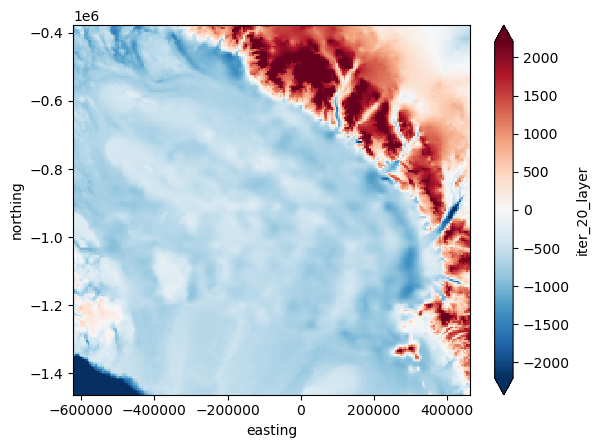

In [7]:
jac_weights = (
    results_weights_in_jac[0]
    .set_index(["northing", "easting"])
    .to_xarray()[results_weights_in_jac[0].columns[-1]]
)
jac_weights.plot(robust=True)

## compare to saved .nc

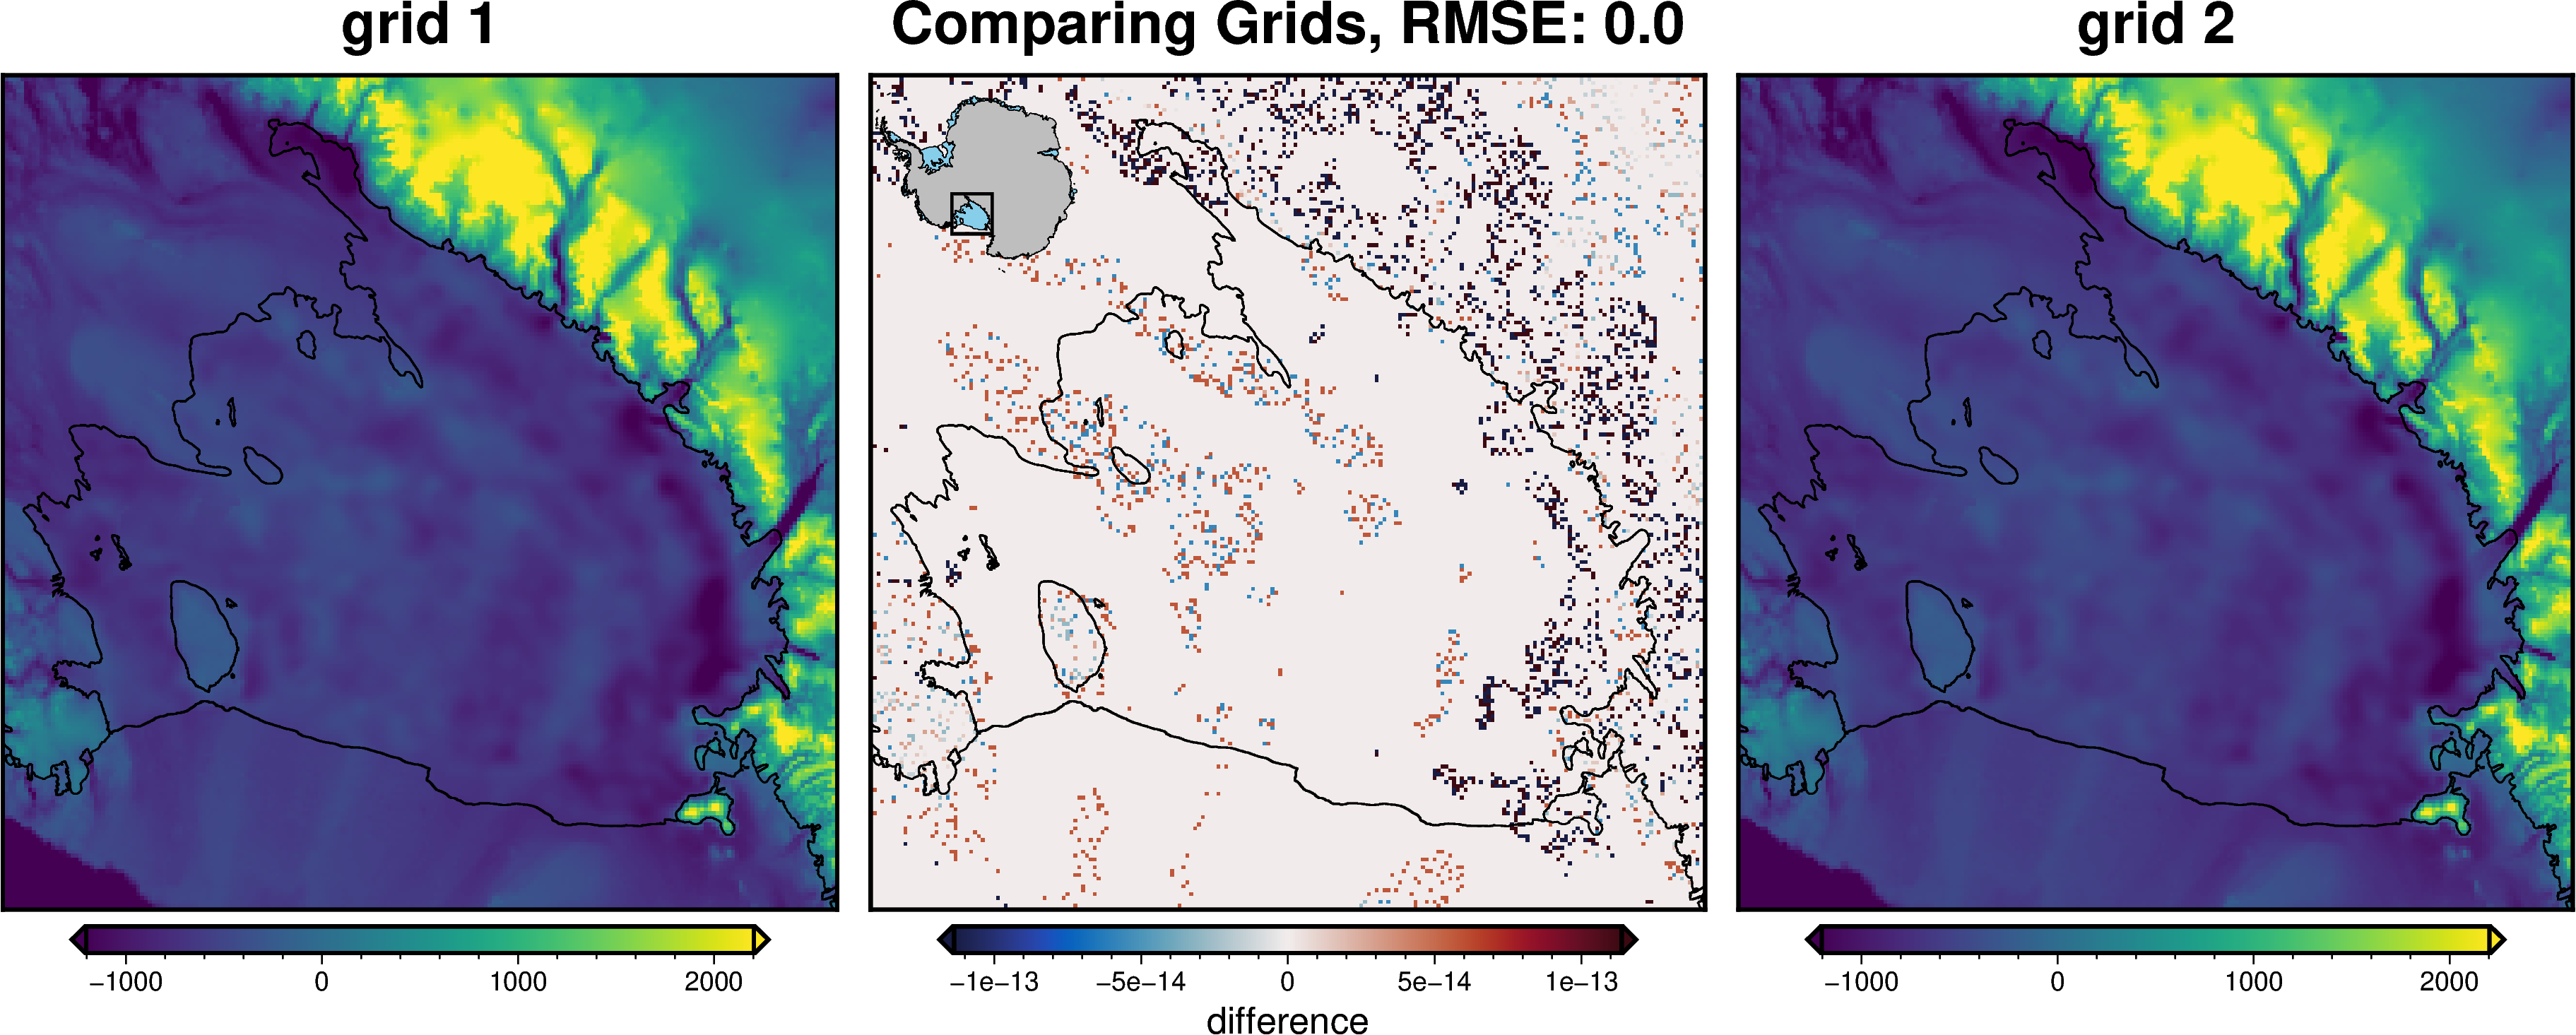

(<xarray.DataArray 'iter_20_layer' (northing: 217, easting: 217)>
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 1.13686838e-13, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.13686838e-13, 0.00000000e+00, 0.00000000e+00, ...,
         5.68434189e-14, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
 Coordinates:
   * northing  (northing) float64 -1.46e+06 -1.455e+06 ... -3.85e+05 -3.8e+05
   * easting   (easting) float64 -6.2e+05 -6.15e+05 -6.1e+05 ... 4.55e+05 4.6e+05,
 <xarray.DataArray 'iter_

In [9]:
_ = utils.grd_compare(
    jac_weights,
    inverted_bathy,
    plot=True,
    plot_type="pygmt",
    robust=True,
)

## redo with weights after Jac

In [10]:
results_weights_after_jac = inv.geo_inversion(
    input_grav=df_anomalies,
    input_grav_column="Gobs_corr_shift",
    prism_layer=starting_prisms,
    # apply_weights = True,
    apply_weights=False,
    weights_after_solving=True,
    max_iterations=20,
    l2_norm_tolerance=0.2,  # 0.01, #.2,
    delta_l2_norm_tolerance=0.8,  # .1, #.8,
    perc_increase_limit=0.2,  # 1000, #.2,
    upper_confining_layer=icebase_layer_spacing,
    deriv_type="annulus",
    solver_type="scipy least squares",
    solver_damping=0.1,
    # save_results=True,
    # fname_prefix= "results/weights_mask",
)


############################################################
iteration 1
number of solver iters:4
Layer correction median: -0.0007 m, RMSE:0.0635 m
enforced upper confining surface at 12533 prisms
updated misfit RMSE: 1.62
updated L2-norm: 1.27,  tolerance: 0.2
updated delta L2-norm : 1.05,  tolerance: 0.8

############################################################
iteration 2
number of solver iters:4
Layer correction median: -0.0007 m, RMSE:0.0576 m
enforced upper confining surface at 12628 prisms
updated misfit RMSE: 1.46
updated L2-norm: 1.21,  tolerance: 0.2
updated delta L2-norm : 1.05,  tolerance: 0.8

############################################################
iteration 3
number of solver iters:4
Layer correction median: -0.0007 m, RMSE:0.0519 m
enforced upper confining surface at 12719 prisms
updated misfit RMSE: 1.33
updated L2-norm: 1.15,  tolerance: 0.2
updated delta L2-norm : 1.05,  tolerance: 0.8

############################################################
iteration 4

In [11]:
results_weights_after_jac[2]

{'density_contrast': '1276 kg/m3',
 'max_iterations': 20,
 'l2_norm_tolerance': '0.2',
 'delta_l2_norm_tolerance': '0.8',
 'jacobian weights': 'Not enabled',
 'deriv_type': 'annulus',
 'jacobian_prism_size': '1 m',
 'solver_type': 'scipy least squares',
 'solver_damping': 0.1,
 'solver_weights': 'Not enabled',
 'upper_confining_layer': 'Enabled',
 'lower_confining_layer': 'Not enabled',
 'max_layer_change_per_iter': 'None m',
 'time_elapsed': '269 seconds',
 'average_iteration_time': '13.44 seconds',
 'Final misfit RMSE / L2-norm': '0.24060981029284334 / 0.4905199387311828 mGal'}

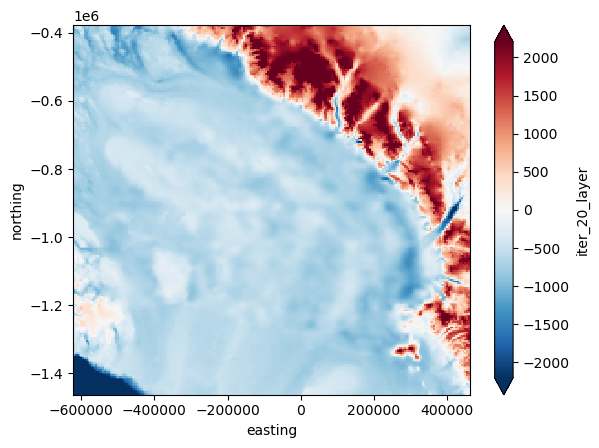

In [12]:
weights_after_jac = (
    results_weights_after_jac[0]
    .set_index(["northing", "easting"])
    .to_xarray()[results_weights_after_jac[0].columns[-1]]
)
weights_after_jac.plot(robust=True)

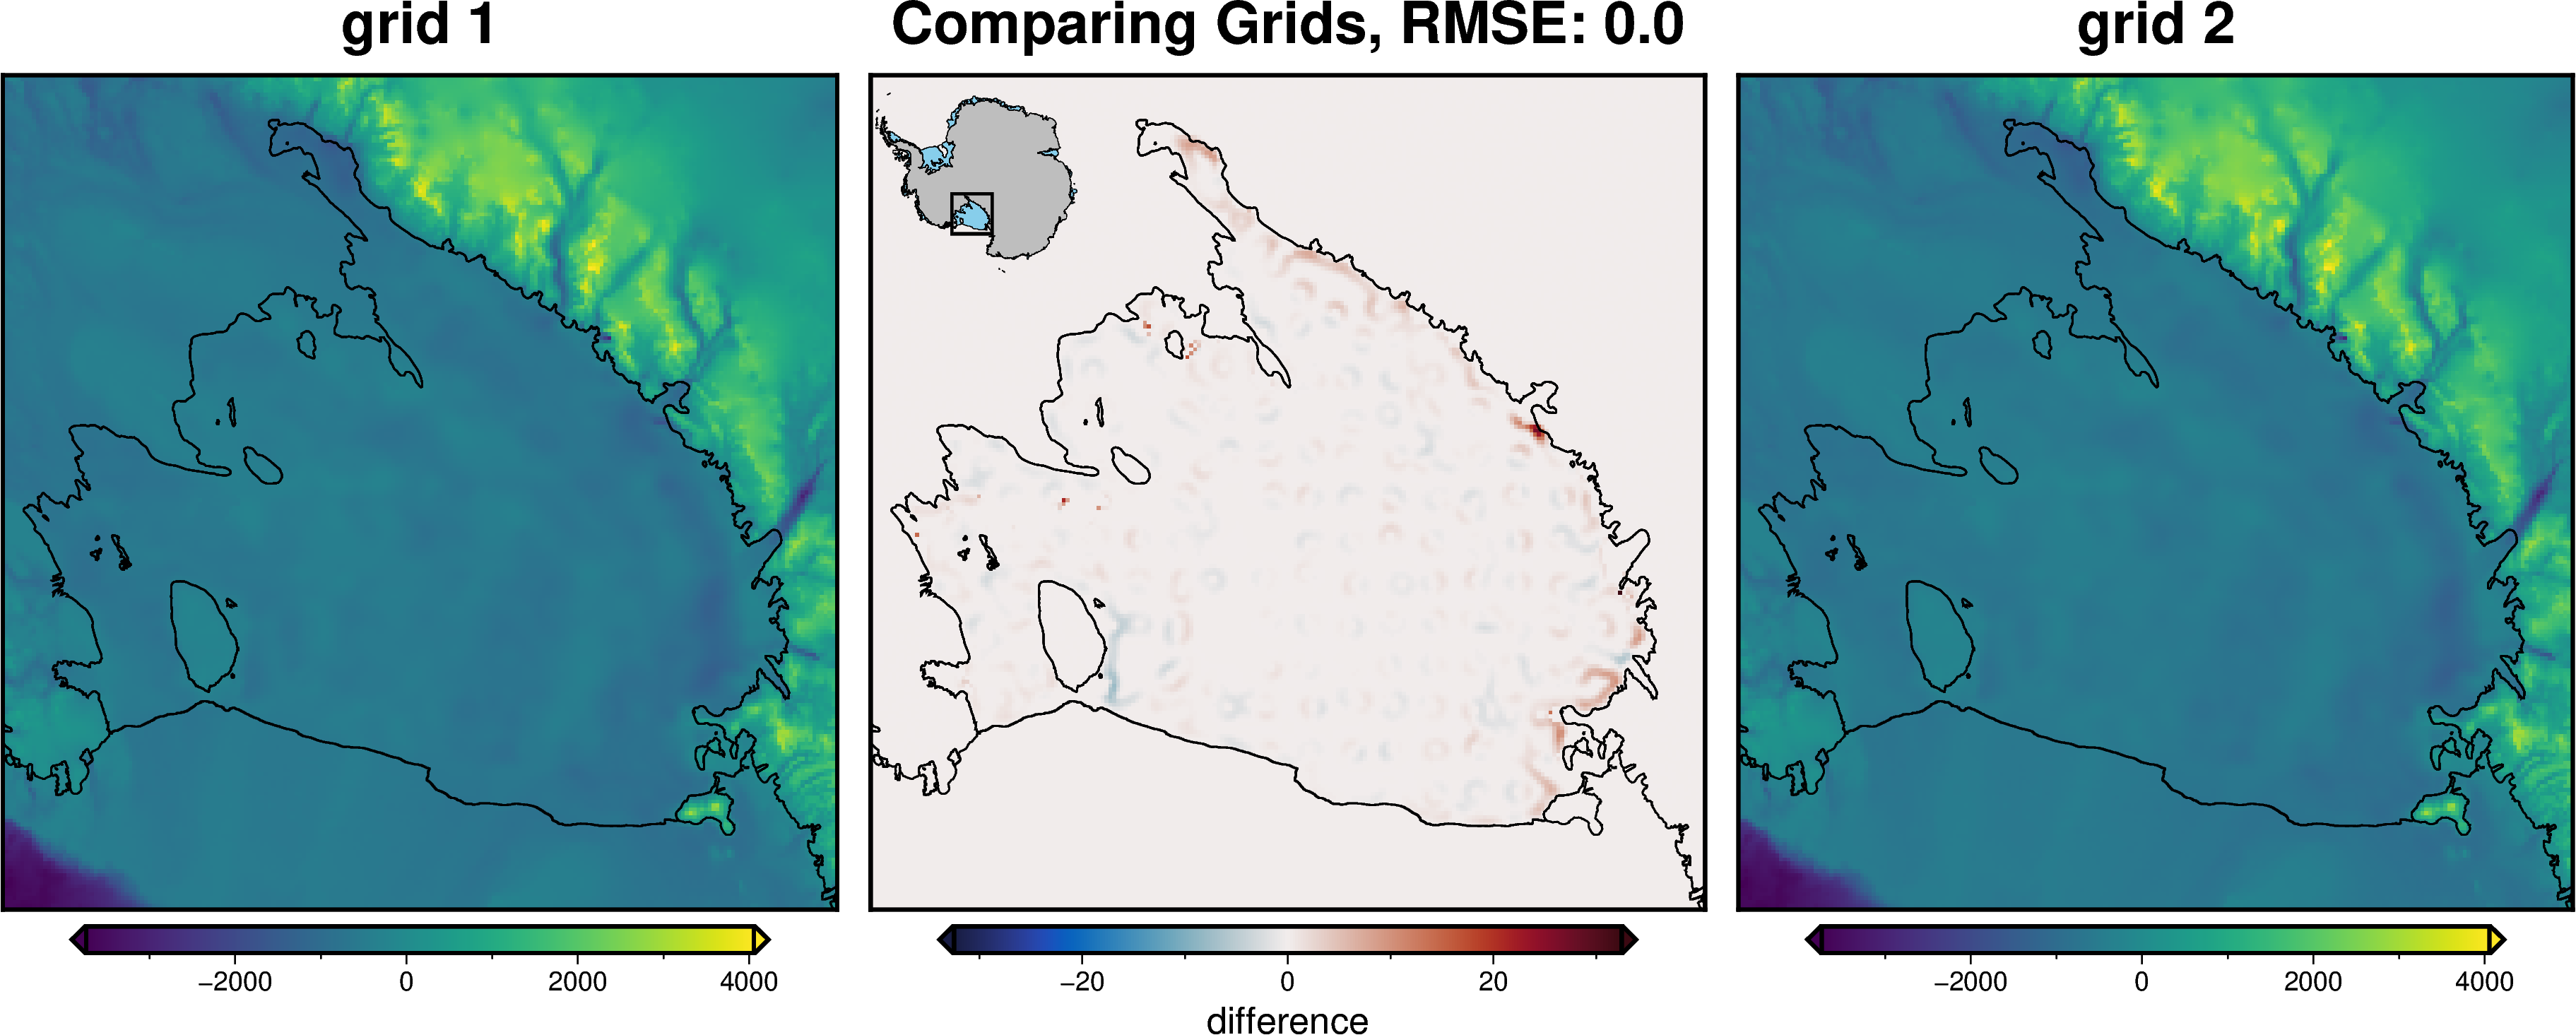

In [14]:
_ = utils.grd_compare(
    jac_weights,
    weights_after_jac,
    plot=True,
    plot_type="pygmt",
    robust=False,  # True,
)

# Plot results

In [ ]:
# prism_results, grav_results, params, elapsed_time = results
# # prism_results = "../results/weights_no_mask_prism_results.csv.gz"
# # grav_results = "../results/weights_no_mask_gravity_results.csv.gz"
# # params = "../results/weights_no_mask_parameters.npy"

# with_weights_grids = plotting.plot_inversion_results(
#     grav_results,
#     prism_results,
#     params,
#     grav_region=inversion_region,
#     grav_spacing=layer_spacing,
#     constraints=constraints,
#     # plot_iter_results=False
#     # plot_topo_results=False,
#     plot_grav_results=False,
#     iters_to_plot=2,
#     shp_mask = "../plotting/RIS_outline.shp",
#     misfit_cmap_perc=.2,
#     topo_cmap_perc=.8,
#     corrections_cmap_perc=.2,
#     )
# with_weights_final_topo = with_weights_grids[1][-1]
# with_weights_topo_diff = bed.rename({"x":"easting","y":"northing"}) - with_weights_final_topo